In [1]:
import math
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

In [2]:
def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d 

Stepsize = 0.03125
[[ 0.4333      0.3333      0.3333      0.3333      0.3333    ]
 [ 0.66632674  0.56938328  0.56803636  0.56941637  0.57078648]
 [ 0.89217506  0.79810511  0.79490372  0.79830336  0.8016404 ]
 ...
 [ 4.24737005 -0.22064781 -2.01103402  3.54410964  9.10505214]
 [ 3.17745923 -1.2577609  -1.69471238  3.10291453  9.6430081 ]
 [ 1.96365338 -1.8735911  -1.41355463  2.70951177  9.96203417]]


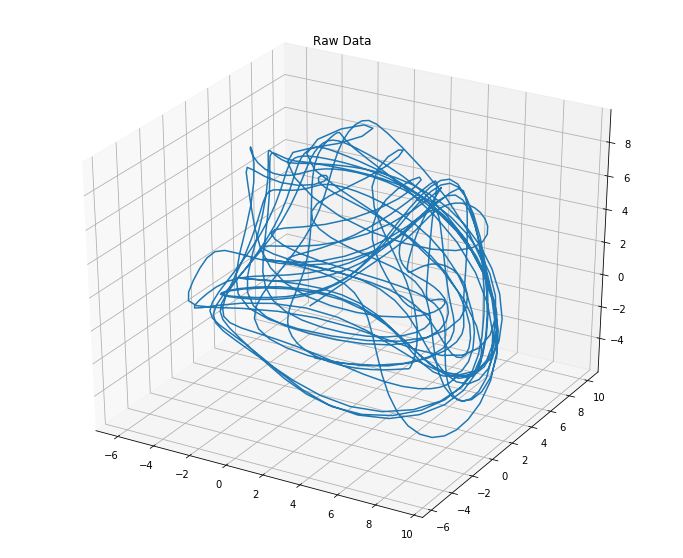

In [3]:
# Step 1
N = 2 ** 10
r = 5

end = 2**5
print("Stepsize = {st}".format(st=end/N))
t = np.linspace(0, end, num=N)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
ndrivers = 1
# t0 = np.array([0.5])
t0 = np.ones(r) * 0.3333 # np.zeros(dim)
t0[0] += 0.1

X = odeint(Lorenz96, t0,t)

"""
X = np.ones((N, r))
for i in range(N):
    for j in range(r):
        X[i,j] = i + j
"""
"""
X = np.array([[0,0,0,0],
              [0,0,0,0.5],
              [5,0,0,0],
              [10,0,0.5,0],
              [10,0,0,0]])
              """

print(X)

fig2 = plt.figure(2,figsize=(12,10))
if r == 1:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],"b") # states
elif r == 2:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],X[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(X[:,0],X[:,1],X[:,2])
ax2.set_title("Raw Data")

plt.show()

In [4]:
# Step 2: chose parameters(how ??)
a = 0.5    # bias parameter, 0.5 matches intrinsic metric of system
k = 6  # number of neighbors
s = 30 # delay

In [5]:
# Step 3: Weighted Embedding

print("Embedding Dimensions: ",N-s, r*(s+1))
Xemb = np.zeros((N-s, r*(s+1)))
for e in range(s+1):
    Xemb[:,e*r:(e+1)*r] = np.exp(-k*e) * X[s-e:N-e,:]
    
print(Xemb, "Works as expected")

Embedding Dimensions:  994 155
[[ 4.88083303e+00  5.29799395e+00  5.31290236e+00 ...  2.23783762e-79
   2.23783762e-79  2.23783762e-79]
 [ 5.05167698e+00  5.48879103e+00  5.38008769e+00 ...  3.81390080e-79
   3.82316643e-79  3.83236565e-79]
 [ 5.25131623e+00  5.67645406e+00  5.40610185e+00 ...  5.33713004e-79
   5.35995590e-79  5.38236140e-79]
 ...
 [ 4.24737005e+00 -2.20647811e-01 -2.01103402e+00 ...  2.17475310e-78
   6.41690081e-78  1.14381609e-78]
 [ 3.17745923e+00 -1.25776090e+00 -1.69471238e+00 ...  2.09498495e-78
   6.50984216e-78  3.67250280e-79]
 [ 1.96365338e+00 -1.87359110e+00 -1.41355463e+00 ...  2.05544283e-78
   6.51421194e-78 -3.51603419e-79]] Works as expected


In [6]:
# QR Decomposition, optional, used to reduce dimensionality

# Step 4: Generate Gaussian Random variables
m = Xemb.shape[1] # TODO: find out where m comes from

pi = np.random.normal(0,1,(m, r*(s+1)))

# Step 5: orthonormalize w/ QR

Q, R = la.qr(pi)
pihat = Q # is this a random orthonormal basis?

np.set_printoptions(suppress=True)

# Step 6: form compressed states
compressedStates = np.zeros(Xemb.shape) # corresponds to y_i hat

for i in range(Xemb.shape[0]):
    compressedStates[i,:] = (pihat @ Xemb[i,:,None]).T

In [7]:
# Step 7: find those neighbors

neighborIndices = np.zeros((Xemb.shape[0],k), dtype=int)

for i in range(Xemb.shape[0]):
    neighborIndices[i,:] = np.argsort(la.norm(Xemb[i,:] - Xemb,axis=1))[1:k+1]
    
print(neighborIndices)

[[  1   2   3   4   5   6]
 [  0   2   3   4   5   6]
 [  1   3   0   4   5   6]
 ...
 [531 530 992 990 438 342]
 [532 993 531 991 439 438]
 [533 992 532 534 440 439]]


In [8]:
# Step 8: 

neighborMatrix = np.zeros((Xemb.shape[0],Xemb.shape[0]))
for point in range(neighborIndices.shape[0]):
    for neighborIndex in neighborIndices[point,:]:
        neighborMatrix[point, neighborIndex] = la.norm(compressedStates[neighborIndex] - compressedStates[point])
        
print(neighborMatrix)

[[0.         0.27014418 0.5546453  ... 0.         0.         0.        ]
 [0.27014418 0.         0.28731818 ... 0.         0.         0.        ]
 [0.5546453  0.28731818 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         1.67464701 0.        ]
 [0.         0.         0.         ... 1.67464701 0.         1.4792504 ]
 [0.         0.         0.         ... 0.         1.4792504  0.        ]]


In [9]:
# Step 9: Normalization

epsilon = np.sum(neighborMatrix ** 2) / Xemb.shape[0]
print(epsilon)

15.885042819067031


In [10]:
# Step 10: make sparse matrix
dhat = np.exp(-1 * np.power(neighborMatrix,2) / epsilon, where=neighborMatrix != 0)
print(dhat)

[[0.         0.99541641 0.98082021 ... 0.         0.         0.        ]
 [0.99541641 0.         0.99481666 ... 0.         0.         0.        ]
 [0.98082021 0.99481666 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.83816013 0.        ]
 [0.         0.         0.         ... 0.83816013 0.         0.87131556]
 [0.         0.         0.         ... 0.         0.87131556 0.        ]]


In [11]:
# Step 11: Make symmetric Matrix

J = (dhat + dhat.T) / 2
print(J)

[[0.         0.99541641 0.98082021 ... 0.         0.         0.        ]
 [0.99541641 0.         0.99481666 ... 0.         0.         0.        ]
 [0.98082021 0.99481666 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.83816013 0.        ]
 [0.         0.         0.         ... 0.83816013 0.         0.87131556]
 [0.         0.         0.         ... 0.         0.87131556 0.        ]]


In [12]:
# Step 12: form diagonal normalization matrix

P = np.diag(np.sum(J,axis=1))
print(P)

[[4.67782844 0.         0.         ... 0.         0.         0.        ]
 [0.         5.23427401 0.         ... 0.         0.         0.        ]
 [0.         0.         5.75662289 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 4.19995696 0.         0.        ]
 [0.         0.         0.         ... 0.         4.26228227 0.        ]
 [0.         0.         0.         ... 0.         0.         4.22809353]]


In [13]:
# Step 13: Normalize and form kernel matrix
# print(np.power(P, -a, where= P != 0))
K = np.power(P, -a, where= P != 0) @ J @ np.power(P,-a, where= P != 0)
print(K)

[[0.         0.20116593 0.18900939 ... 0.         0.         0.        ]
 [0.20116593 0.         0.18123035 ... 0.         0.         0.        ]
 [0.18900939 0.18123035 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.19809954 0.        ]
 [0.         0.         0.         ... 0.19809954 0.         0.20524948]
 [0.         0.         0.         ... 0.         0.20524948 0.        ]]


In [14]:
# Step 14: 

Q = np.diag(np.sum(K,axis=1))
print(Q)


[[0.87599638 0.         0.         ... 0.         0.         0.        ]
 [0.         0.93183458 0.         ... 0.         0.         0.        ]
 [0.         0.         0.9779758  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.90183535 0.         0.        ]
 [0.         0.         0.         ... 0.         0.91793353 0.        ]
 [0.         0.         0.         ... 0.         0.         0.9481932 ]]


In [15]:
# Step 15: Form symmetric Matrix

""" NOTE: pronounced T-hat """ 
That = np.power(Q, -0.5, where= Q != 0) @ K @ np.power(Q,-0.5, where= Q != 0)
print(That)

[[0.         0.22265572 0.20420584 ... 0.         0.         0.        ]
 [0.22265572 0.         0.18984426 ... 0.         0.         0.        ]
 [0.20420584 0.18984426 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.21772797 0.        ]
 [0.         0.         0.         ... 0.21772797 0.         0.22000271]
 [0.         0.         0.         ... 0.         0.22000271 0.        ]]


In [16]:
# Step 16: Eigenvectors and values

eigenValuesThat, eigenVectorsThat = la.eigh(That)

print(eigenValuesThat,"\n", eigenVectorsThat)

[-0.71568805 -0.67317405 -0.64424713 -0.62971099 -0.61580672 -0.61414702
 -0.6050488  -0.60018777 -0.59876158 -0.5944795  -0.59197888 -0.57576082
 -0.56612667 -0.56572849 -0.56555198 -0.55914744 -0.55689575 -0.5469614
 -0.5453168  -0.54117301 -0.53858702 -0.53784335 -0.53141664 -0.53064809
 -0.52762258 -0.52532395 -0.52406678 -0.52260037 -0.51698001 -0.51488254
 -0.51232499 -0.51133865 -0.50753466 -0.50623074 -0.50474216 -0.50238768
 -0.50159983 -0.50031997 -0.49981216 -0.49744437 -0.49501722 -0.49399682
 -0.49233297 -0.49005262 -0.48943706 -0.48767374 -0.48595115 -0.48522263
 -0.48292877 -0.48196429 -0.48110821 -0.47991956 -0.47527716 -0.47310815
 -0.47219144 -0.47044497 -0.46996192 -0.46898848 -0.46675628 -0.46638972
 -0.46550496 -0.46504645 -0.46445841 -0.46250783 -0.46012151 -0.45964528
 -0.45941429 -0.45743367 -0.45707098 -0.45404327 -0.45068209 -0.45038682
 -0.44932133 -0.44907407 -0.44790505 -0.44744575 -0.44623779 -0.44579984
 -0.44337291 -0.44212168 -0.44163028 -0.44073811 -0.

In [17]:
# Step 17: find T hat ^1/e eigenvalues

""" WARNING : DID ABSOLUTE VALUE TO DEAL WITH NEGATIVE EIGENVALS, COULD BE WRONG"""
eigenValuesThat = np.power(abs(eigenValuesThat), 1/(2*epsilon))
print(eigenValuesThat)

[0.98952612 0.98762053 0.98625611 0.98554791 0.98485551 0.98477186
 0.98430933 0.98405944 0.98398575 0.98376348 0.98363297 0.98277329
 0.98225143 0.98222968 0.98222003 0.98186799 0.98174329 0.98118722
 0.98109423 0.9808587  0.98071083 0.98066817 0.98029718 0.98025253
 0.98007612 0.97994144 0.97986754 0.97978112 0.97944771 0.97932239
 0.9791689  0.97910951 0.97887941 0.97880015 0.97870943 0.9785654
 0.97851706 0.97843838 0.97840711 0.97826088 0.97811028 0.97804675
 0.97794289 0.9778     0.97776132 0.97765024 0.97754136 0.9774952
 0.97734941 0.97728791 0.97723323 0.97715714 0.97685822 0.97671758
 0.97665796 0.97654405 0.97651247 0.97644874 0.97630212 0.97627798
 0.97621963 0.97618935 0.97615047 0.97602117 0.97586227 0.97583046
 0.97581502 0.97568232 0.97565796 0.97545388 0.97522577 0.97520565
 0.97513295 0.97511606 0.97503606 0.97500457 0.97492161 0.97489148
 0.97472398 0.97463728 0.97460317 0.97454113 0.97441876 0.97431268
 0.9742206  0.9741831  0.9739997  0.97396728 0.97390728 0.973752

In [18]:
# Step 18: find eigenvec of T

eigenVectorsT = np.power(Q, -0.5,where= (Q!=0) ) @ eigenVectorsThat
print(eigenVectorsT)


[[ 0.00000125 -0.00001643  0.00003379 ... -0.06371432  0.03390722
  -0.03180771]
 [ 0.00000191 -0.00002624  0.00005586 ... -0.06369134  0.03389941
  -0.03180771]
 [ 0.00000387 -0.00006295  0.00015858 ... -0.0636503   0.03388547
  -0.03180771]
 ...
 [ 0.00000019 -0.00001822  0.00018824 ...  0.01817226 -0.05588931
  -0.03180771]
 [-0.00000007  0.00000644 -0.00007397 ...  0.0208659  -0.05518878
  -0.03180771]
 [-0.00000004  0.0000003   0.00001453 ...  0.02321676 -0.05421663
  -0.03180771]]


In [19]:
# Step 19: Compute Diffusion Map Variables

L = 6 # final dimension of reduced system
t = 5 # Number of diffusion steps (imagine raising the markov probability matrix to this power)
diffusionMap = (eigenValuesThat ** t) * eigenVectorsT
print(diffusionMap)

[[ 0.00000119 -0.00001544  0.00003153 ... -0.06367876  0.03389514
  -0.03180771]
 [ 0.00000182 -0.00002466  0.00005212 ... -0.06365579  0.03388733
  -0.03180771]
 [ 0.00000367 -0.00005915  0.00014797 ... -0.06361477  0.03387339
  -0.03180771]
 ...
 [ 0.00000018 -0.00001712  0.00017566 ...  0.01816211 -0.05586939
  -0.03180771]
 [-0.00000006  0.00000606 -0.00006903 ...  0.02085426 -0.05516911
  -0.03180771]
 [-0.00000004  0.00000028  0.00001356 ...  0.0232038  -0.05419731
  -0.03180771]]


In [20]:
# Step 20: Print Timescales

print(-1 / np.log(eigenValuesThat))

[   94.97474313    80.27789273    72.25846145    68.69292104
    65.52936453    65.16660732    63.230825      62.23172077
    61.94305797    61.08820672    60.59705543    57.54793972
    55.84108852    55.77211761    55.74158115    54.64955323
    54.27284267    52.65378605    52.3923073     51.74144141
    51.34093055    51.22654556    50.25250994    50.13773213
    49.68935599    49.35234384    49.16933574    48.95702651
    48.15465512    47.859742      47.50339431    47.36691068
    46.845386      46.66837015    46.46736072    46.15174596
    46.04676363    45.87688624    45.80971248    45.49818171
    45.18169784    45.04949748    44.83500525    44.54317492
    44.46481715    44.24133482    44.024402      43.93306689
    43.64705523    43.52750654    43.42174257    43.27543104
    42.70992831    42.44890186    42.33918319    42.13112892
    42.07381022    41.95859475    41.69586874    41.65292108
    41.54948233    41.49600245    41.42753861    41.20143135
    40.9268726     40.87

C:\Users\Kenneth\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


b:\python\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


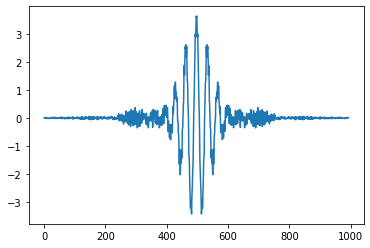

In [21]:
figDM, axDM = plt.subplots(1)
axDM.plot(np.fft.fft(diffusionMap[:,0]))

plt.show()

In [22]:
# Step 21: form DMDC projections

q = Q @ diffusionMap
print(q.shape)

(994, 994)


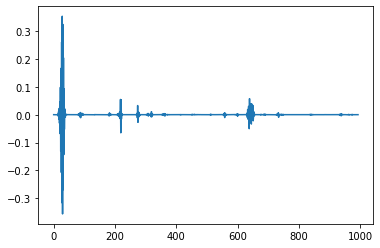

In [24]:
figDM, axDM = plt.subplots(1)
axDM.plot(q[:,0])

plt.show()